The data is Unevenly spaced time series?. 
Many date is missing.<br>

https://en.wikipedia.org/wiki/Unevenly_spaced_time_series


#date  	  int   	  日期，经过脱敏，用数字来表示  
#day_of_week  	  int  	  表示星期几  
#brand  	  int  	  汽车品牌  
#cnt  	  int  	  上牌数  


In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import date,timedelta
from dateutil.relativedelta import *
#machine lerning
from sklearn.model_selection import train_test_split


#test time stationary    
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [482]:
#helper function

def drop_brand( df ):
    cols = list(df.columns)
    if 'brand' in cols:
        df = df[["date",'day_of_week' ,"cnt"]].groupby(['date','day_of_week' ] , as_index =False).sum()
    return df

def how_many_weeks (df):
    df = drop_brand(df)
    week_cnt=0;
    weekdays=[]
    weekday=0
    prev=-1
    for idx ,row in df.iterrows():
        weekday+=1
        if row['day_of_week']<= prev:
            weekdays.append(weekday)
            weekday=0
            week_cnt+=1;
        prev=row['day_of_week']
    week_cnt
    weekdays = np.asarray(weekdays)
    return week_cnt,weekdays

#将脱敏的日期变为正常日期
#加入周数ID 与 月数ID
def add_actual_date (df,start_date = date(2003,1,1) ,week_cnt=1, month_cnt=1):
    #start_date = date(2003,1,1)    
    df = drop_brand(df)
    df["real_date"] = start_date
    
    
    add_days=-1
    prev_week_days=0
    prev=df.loc[0,"day_of_week"]-1.0
    prev_month = month_cnt
    for idx ,row in df.iterrows():
        
        
        if row['day_of_week']<= prev:
            add_days+=row['day_of_week']+7-prev
            week_cnt+=1
        else:
            add_days+=(row['day_of_week']-prev)
        df.loc[idx,"real_date"] += timedelta(days=add_days)
        df.loc[idx,"week"] = week_cnt
        prev=row['day_of_week']
        if df.loc[idx,"real_date"].month != prev_month:
            month_cnt+=1
        df.loc[idx,"month"] = month_cnt     
        prev_month = df.loc[idx,"real_date"].month
        
    df["real_date"]=df["real_date"].astype("datetime64[ns]")
    return df

#给Weekly数据的
#返回一行按周的日期
def add_week_date (df,start_date = date(2003,1,1)):
    df=df.copy()
    
    if "cnt" not in df.columns:
        df["cnt"]=0
    df["weekdays"] =df[["cnt","week"]].groupby(['week' ] ).transform("count")
    df["cnt_ave_week"] =df[["cnt","week"]].groupby(['week' ] ).transform("mean")
    df = df.drop_duplicates(subset=['week'] , keep='first')

    add_days=0
    #df["week_date"]=0
    for idx ,row in df.iterrows():       
        df.loc[idx,"week_date"]=  start_date+timedelta(days=add_days)
        add_days+=7
    df["week_date"]=df["week_date"].astype("datetime64[ns]")
    df=df.set_index('week_date')
    df=df[["cnt_ave_week"]]
    return df


#给Monthly数据的
#返回一行按月的日期
def add_month_date (df,start_date = date(2003,1,1)):   
    df=df.copy()
    
    if "cnt" not in df.columns:
        df["cnt"]=0
    df["monthdays"] =df[["cnt","month"]].groupby(['month' ] ).transform("count")
    df["cnt_ave_month"] =df[["cnt","month"]].groupby(['month' ] ).transform("mean")
    df = df.drop_duplicates(subset=['month'] , keep='first')
    
    add_days=0
    #df["week_date"]=0
    for idx ,row in df.iterrows():       
        df.loc[idx,"month_date"]=start_date
        start_date += relativedelta(months=1)
    df["month_date"]=df["month_date"].astype("datetime64[ns]")
    df=df.set_index('month_date')
    df=df[["cnt_ave_month"]]
    #df = df.loc[:,['week_date','cnt_ave_week']]
    return df

def plot_correlation_map( df ):

    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )



def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()
    
    #plt.figure(figsize=(20,10))
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [457]:
#读数据
data_train = pd.read_table('input/train_20171215.txt')
data_test_a = pd.read_table('input/test_A_20171225.txt')
data_test_b = pd.read_table('input/test_B_20171225.txt')
data_train.head(10)
#通过周数可以得知总共的数据为5年
total_weeks = how_many_weeks(data_train)+how_many_weeks(data_test_a) +how_many_weeks(data_test_b)
print("Total weeks are:",total_weeks[0],". Which are for 5 years (52 weeks/year)")

Total weeks are: 170 . Which are for 5 years (52 weeks/year)


In [458]:
#为数据加入日期
train_by_date = add_actual_date(data_train)
test_a_by_date = add_actual_date(data_test_a,
                                 start_date=train_by_date.real_date.max(),
                                 week_cnt=train_by_date.week.max(),
                                 month_cnt = train_by_date.month.max())
test_b_by_date = add_actual_date(data_test_b,
                                 start_date=test_a_by_date.real_date.max()+timedelta(days=1),
                                 week_cnt=test_a_by_date.week.max(),
                                month_cnt = test_a_by_date.month.max())
#为training date加入 周 和 月的平均
# train_by_date["weekdays"] =train_by_date[["cnt","week"]].groupby(['week' ] ).transform("count")
# train_by_date["cnt_ave_week"] =train_by_date[["cnt","week"]].groupby(['week' ] ).transform("mean")

# train_by_date["monthdays"] =train_by_date[["cnt","month"]].groupby(['month' ] ).transform("count")
# train_by_date["cnt_ave_month"] =train_by_date[["cnt","month"]].groupby(['month' ] ).transform("mean")

#train_by_date.loc[train_by_date["week"]==40.0,:]
#by_date_day["real_date"]=by_date_day["real_date"].astype("str")

In [459]:
#看改过的数据的tail和head

print(train_by_date.tail())
print(test_a_by_date.head())
print(test_a_by_date.tail())
print(test_b_by_date.head())
print(test_b_by_date.tail())

      date  day_of_week   cnt  real_date   week  month
1027  1028            5  2519 2006-03-31  170.0   39.0
1028  1029            6   195 2006-04-01  170.0   40.0
1029  1030            2  4003 2006-04-04  171.0   40.0
1030  1031            3  2513 2006-04-05  171.0   40.0
1031  1032            4  1306 2006-04-06  171.0   40.0
   date  day_of_week  real_date   week  month
0  1032            4 2006-04-06  171.0   41.0
1  1033            5 2006-04-07  171.0   41.0
2  1034            6 2006-04-08  171.0   41.0
3  1035            1 2006-04-10  172.0   41.0
4  1036            2 2006-04-11  172.0   41.0
     date  day_of_week  real_date   week  month
271  1303            6 2007-02-10  215.0   51.0
272  1304            1 2007-02-12  216.0   51.0
273  1305            2 2007-02-13  216.0   51.0
274  1306            3 2007-02-14  216.0   51.0
275  1307            4 2007-02-15  216.0   51.0
   date  day_of_week  real_date   week  month
0  1308            5 2007-02-16  216.0   52.0
1  1309       

In [476]:
#成为weekly的每周平均cnt
# data_train_weekly = train_by_date.drop_duplicates(subset=['week'] , keep='first')
# test_a_weekly = test_a_by_date.drop_duplicates(subset=['week'] , keep='first')
data_train_weekly.shape
#data_train_weekly.plot(x='week', y='cnt_ave_week',figsize=(20,10))
#给周的数据加时间
data_train_weekly=add_week_date(train_by_date)
test_a_weekly=add_week_date(test_a_by_date,start_date=data_train_weekly.index.max())



In [478]:
#给月加数据
# data_train_monthly = train_by_date.drop_duplicates(subset=['month'] , keep='first')
# test_a_monthly = test_a_by_date.drop_duplicates(subset=['month'] , keep='first')

data_train_monthly=add_month_date(train_by_date)
data_train_monthly.head()

,cnt_ave_month
month_date,
2003-01-01,2507.931034
2003-02-01,1831.681818
2003-03-01,1219.535714
2003-04-01,1297.444444
2003-05-01,1690.250000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171 entries, 2003-01-01 to 2006-04-05
Data columns (total 1 columns):
cnt_ave_week    171 non-null float64
dtypes: float64(1)
memory usage: 2.7 KB


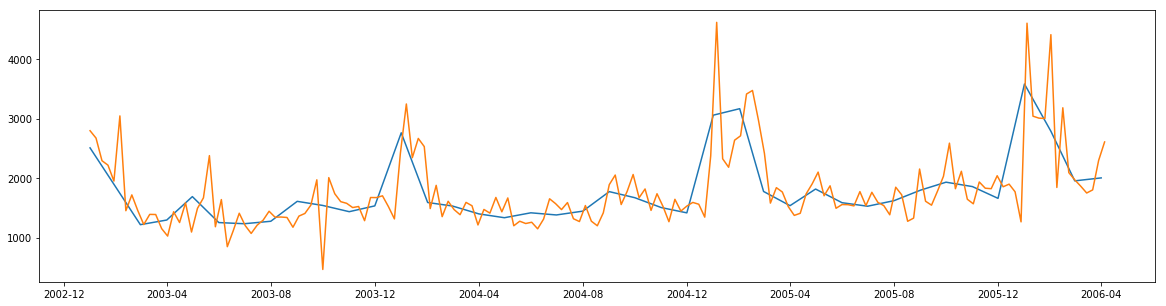

In [536]:
plt.figure(figsize=(20,5))
plt.plot(data_train_monthly['cnt_ave_month'])
plt.plot(data_train_weekly['cnt_ave_week'])
data_train_weekly.info()

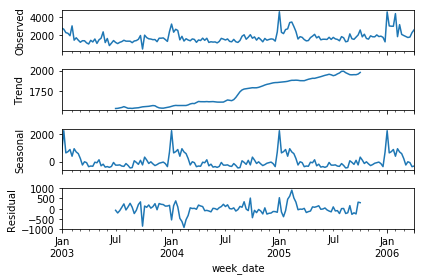

In [534]:
############模型#####

#对月的数据进行forecast


decomposition = seasonal_decompose(data_train_weekly, model='additive')
fig = decomposition.plot()
plt.show()

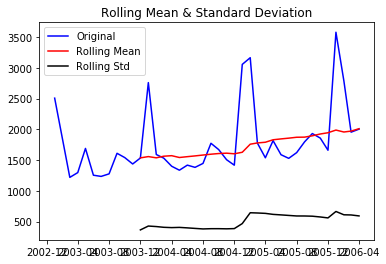

Results of Dickey-Fuller Test:
Test Statistic                 -4.095888
p-value                         0.000984
#Lags Used                      0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


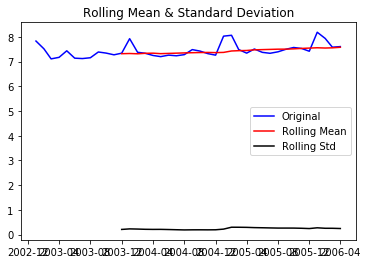

Results of Dickey-Fuller Test:
Test Statistic                 -3.934748
p-value                         0.001793
#Lags Used                      0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
month_date
2003-01-01    2507.931034
2003-02-01    1831.681818
2003-03-01    1219.535714
2003-04-01    1297.444444
2003-05-01    1690.250000
2003-06-01    1254.740741
2003-07-01    1235.266667
2003-08-01    1276.571429
2003-09-01    1610.961538
2003-10-01    1541.740741
2003-11-01    1437.346154
2003-12-01    1534.769231
2004-01-01    2760.807692
2004-02-01    1591.153846
2004-03-01    1532.678571
2004-04-01    1400.481481
2004-05-01    1336.142857
2004-06-01    1418.518519
2004-07-01    1382.444444
2004-08-01    1446.481481
2004-09-01    1774.000000
2004-10-01    1671.840000
2004-11-01    1506.370370
2004-12-01    1417.777778
2005-01-01    3056.928571
2005-0

C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 9869128.3377')

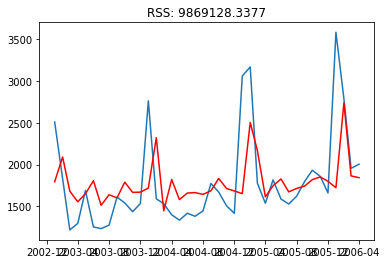

In [526]:



#data_train_monthly.plot()
#data_train_monthly.to_csv("monthly.csv")

ts_month = data_train_monthly['cnt_ave_month']
log_ts_month = np.log(ts_month)
#plt.plot(ts)
test_stationarity(ts_month)
test_stationarity(np.log(ts_month))

log_ts_month = log_ts_month - log_ts_month.shift()


#ACF and PACF plots:
# from statsmodels.tsa.stattools import acf, pacf

#ag_acf = acf(ts_month, nlags=12)
# lag_pacf = pacf(log_ts_month, nlags=20, )

# plt.subplot(121) 
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(log_ts_month)),linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(log_ts_month)),linestyle='--',color='gray')
# plt.title('Autocorrelation Function')

# #Plot PACF:
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(log_ts_month)),linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(log_ts_month)),linestyle='--',color='gray')
# plt.title('Partial Autocorrelation Function')
# plt.tight_layout()

model = ARIMA(ts_month, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_month)
print(ts_month)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_month)**2))

            cnt_ave_week
week_date               
2006-03-08   1865.166667
2006-03-15   1750.833333
2006-03-22   1803.000000
2006-03-29   2297.000000
2006-04-05   2607.333333
            cnt_ave_week
week_date               
2006-04-05             0
2006-04-12             0
2006-04-19             0
2006-04-26             0
2006-05-03             0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171 entries, 2003-01-01 to 2006-04-05
Data columns (total 1 columns):
cnt_ave_week    171 non-null float64
dtypes: float64(1)
memory usage: 2.7 KB


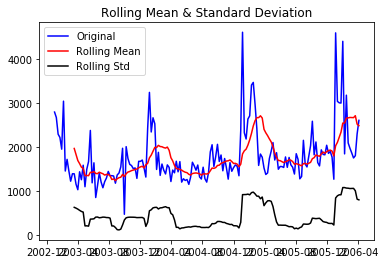

Results of Dickey-Fuller Test:
Test Statistic                  -4.789223
p-value                          0.000057
#Lags Used                       1.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.469648
Critical Value (5%)             -2.878799
Critical Value (10%)            -2.575971
dtype: float64


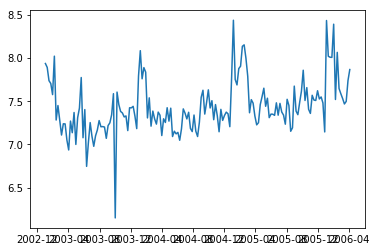

In [491]:
print(data_train_weekly.tail())
print(test_a_weekly.head())
data_train_weekly.info()
#time series data
ts = data_train_weekly['cnt_ave_week'] 

#plt.plot(ts)
test_stationarity(ts)
ts_log = np.log(ts)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
plt.plot(ts_log)

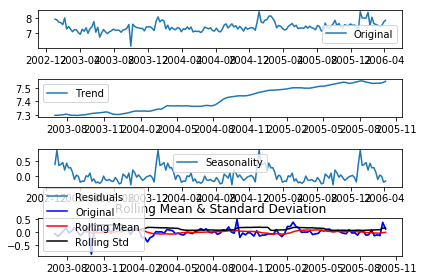

Results of Dickey-Fuller Test:
Test Statistic                -6.465383e+00
p-value                        1.409509e-08
#Lags Used                     1.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


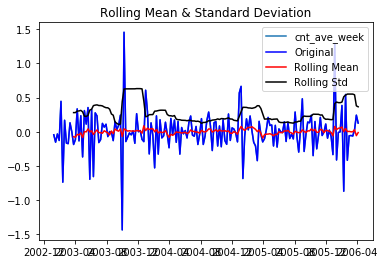

Results of Dickey-Fuller Test:
Test Statistic                -1.080164e+01
p-value                        2.010788e-19
#Lags Used                     2.000000e+00
Number of Observations Used    1.670000e+02
Critical Value (1%)           -3.470126e+00
Critical Value (5%)           -2.879008e+00
Critical Value (10%)          -2.576083e+00
dtype: float64


In [492]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
# ts_log_diff.to_csv("ts.csv")

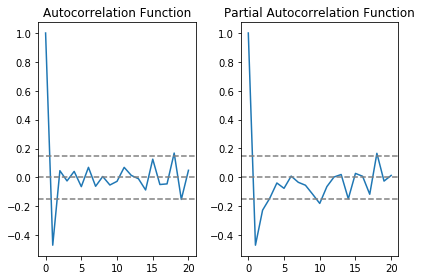

In [499]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 10.7130')

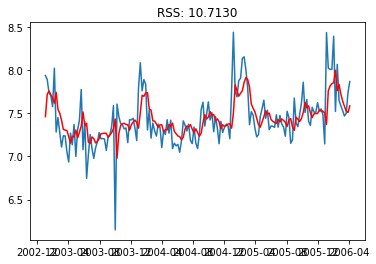

In [500]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log)**2))

In [374]:
further = np.exp(results_ARIMA.forecast(steps=100)[0])
further = pd.Series(further, copy=True)


month_date
2003-01-01    1794.264251
2003-02-01    2089.575982
2003-03-01    1681.832038
2003-04-01    1555.544306
2003-05-01    1651.905253
dtype: float64
2003-01-01    1802.200267
2003-01-08       7.936017
2003-01-15       7.936017
2003-01-22       7.936017
2003-01-29       7.936017
dtype: float64
week_date
2003-01-01    2796.200000
2003-01-08    2672.500000
2003-01-15    2292.571429
2003-01-22    2218.166667
2003-01-29    1951.285714
Name: cnt_ave_week, dtype: float64


C:\Users\csyic\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


Text(0.5,1,'RMSE: nan')

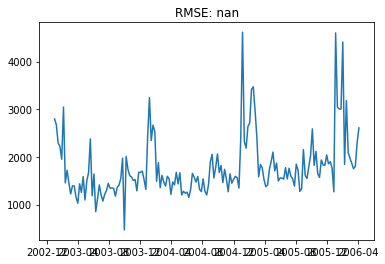

In [508]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())
predictions_ARIMA = np.exp(predictions_ARIMA_diff)
#print(predictions_ARIMA.head(100))
print(ts.head())
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% (sum((predictions_ARIMA-ts)**2)/len(ts)))



In [358]:
predict_test_a_weekly = pd.read_csv('input/predict_test_a_weekly.csv')
predict_test_a_weekly["week"] = predict_test_a_weekly["week"].astype("float64")
result_weekly_tbats = pd.merge(test_a_by_date, predict_test_a_weekly, on='week')
print(result_weekly_tbats.shape,test_a.shape,test_a_by_date.shape,predict_test_a_weekly.shape)

(273, 5) (276, 4) (276, 4) (45, 2)


In [375]:
#周末上牌少
sum_by_day=data_train[["day_of_week" ,"cnt"]].groupby(['day_of_week' ] , as_index =False).median().sort_values(by='cnt', ascending=False)
mean_day = sum_by_day["cnt"].mean()
sum_by_day['ave'] = sum_by_day.transform(lambda row: row["cnt"]/mean_day , axis=1)
sum_by_day.head(7)

for idx,row in result_weekly_tbats.iterrows():
    result_weekly_tbats.loc[idx,"cnt"]=row["cnt"]*sum_by_day.loc[row["day_of_week"]-1,"ave"]
result_weekly_tbats.head(10)
result_weekly_tbats=result_weekly_tbats.drop(["day_of_week","real_date","week"] , axis=1)
result_weekly_tbats.cnt=result_weekly_tbats.cnt.astype("int64")
result_weekly_tbats.to_csv("test_a_submit.txt",index=None,sep='\t')

C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


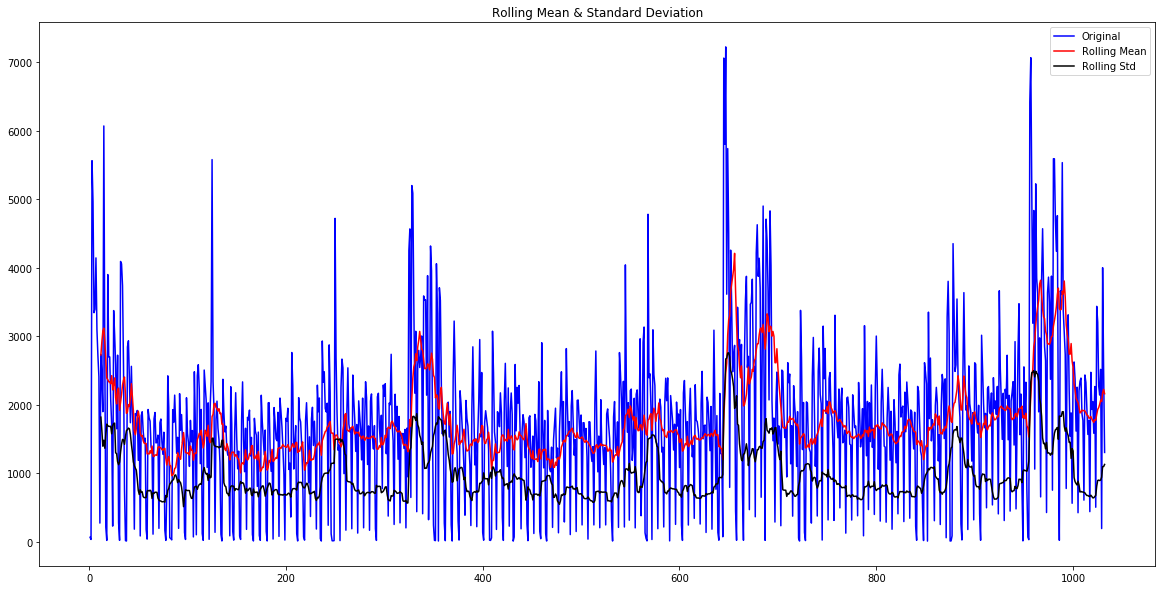

Results of Dickey-Fuller Test:
Test Statistic                   -4.906382
p-value                           0.000034
#Lags Used                       11.000000
Number of Observations Used    1020.000000
Critical Value (1%)              -3.436777
Critical Value (5%)              -2.864378
Critical Value (10%)             -2.568281
dtype: float64
[ 1.          0.2869884   0.0780555   0.03125833  0.09254919  0.08119867
  0.43709908  0.24885329  0.04551859 -0.00902343  0.04061353  0.11249685
  0.34135316  0.22074809  0.08731536  0.00181796  0.01532353  0.06854579
  0.26441149  0.20625644  0.09667736] [ 1.          0.28703107 -0.0043076   0.00917837  0.08843186  0.03357613
  0.44256843  0.02147026 -0.06166523 -0.00742792 -0.02170536  0.1224111
  0.17031906 -0.02546642  0.03686061 -0.01731739 -0.00987196  0.02842332
  0.06567313  0.01715831  0.01192802]


In [298]:
by_date2=data_train[["date" ,"cnt"]].groupby(['date' ] ).sum()
test_stationarity(by_date2["cnt"])

lag_acf = acf(by_date2["cnt"], nlags=20)
lag_pacf = pacf(by_date2["cnt"], nlags=20, method='ols')
print (lag_acf,lag_pacf)

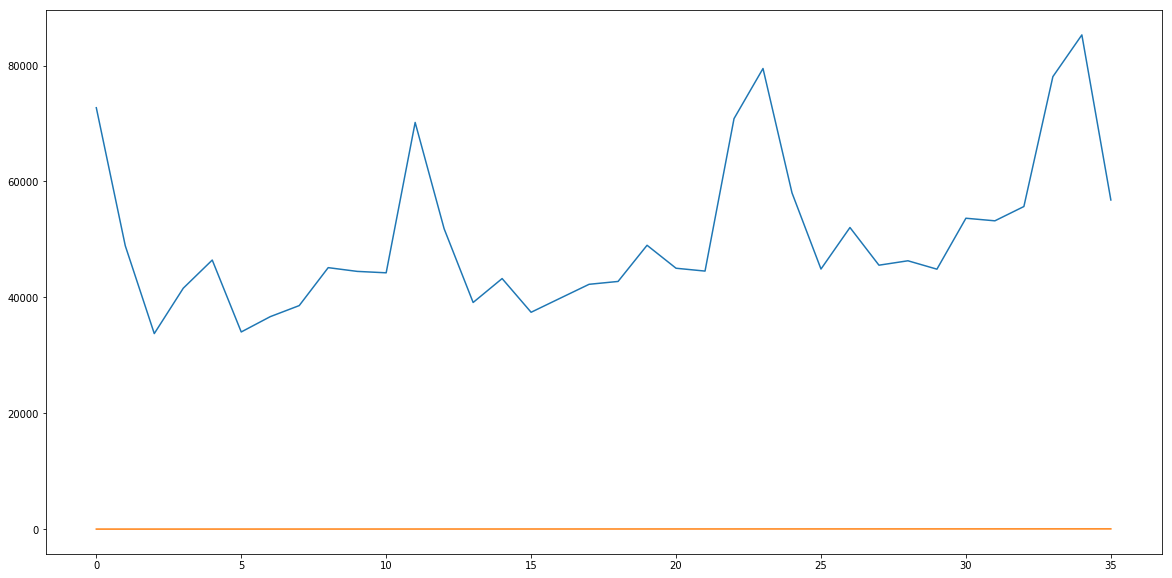

In [299]:
#按月plot 一下
by_date_by_month=by_date
by_date_by_month['month'] = pd.cut(by_date['date'] , 36)
by_date_by_month =by_date_by_month.drop(['date'],axis=1).groupby(['month' ] , as_index =False).sum()

month_range = by_date_by_month.month.values

for idx, val in enumerate(month_range):
     by_date_by_month.loc[ by_date_by_month['month'] == val, 'month2'] = idx
by_date_by_month = by_date_by_month.drop(['month'],axis=1)

#by_date_by_month.info()
plt.figure(figsize=(20,10))
plt.plot(by_date_by_month)